In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim

from copy import deepcopy

# import torch.nn.init as init 

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)  # 첫 번째 히든 레이어
        self.fc2 = nn.Linear(hidden1, hidden2)     # 두 번째 히든 레이어
        self.fc3 = nn.Linear(hidden2, num_classes) # 출력 레이어
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # 첫 번째 히든 레이어에 ReLU 활성화 함수 적용
        x = torch.relu(self.fc2(x))  # 두 번째 히든 레이어에 ReLU 활성화 함수 적용
        x = torch.softmax(self.fc3(x), dim=1)  # 출력층에 softmax 활성화 함수 적용
        return x

# 모델 초기화
input_size = 784  # 입력 크기 (예: 28x28 픽셀 이미지를 펼친 형태)
hidden1 = 64      # 첫 번째 히든 레이어 뉴런 수
hidden2 = 32      # 두 번째 히든 레이어 뉴런 수
num_classes = 10  # 출력 클래스 수 (예: 10개의 숫자)

student = MLP(input_size, hidden1, hidden2, num_classes)
teacher = deepcopy(student)

In [2]:
# from ramp.py

import numpy as np


def sigmoid_rampup(current, rampup_length):
    """Exponential rampup from https://arxiv.org/abs/1610.02242"""
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))


def linear_rampup(current, rampup_length):
    """Linear rampup"""
    assert current >= 0 and rampup_length >= 0
    if current >= rampup_length:
        return 1.0
    else:
        return current / rampup_length


def cosine_rampdown(current, rampdown_length):
    """Cosine rampdown from https://arxiv.org/abs/1608.03983"""
    assert 0 <= current <= rampdown_length
    return float(.5 * (np.cos(np.pi * current / rampdown_length) + 1))

In [3]:
# from https://github.com/CuriousAI/mean-teacher/blob/master/pytorch/main.py

initial_lr = 1e-5
lr = 1e-3
total_epochs= 250
lr_rampup_epochs= 10
lr_rampdown_epochs = total_epochs + 10 # 그냥 10 더하기

consis_weight= 1
consistency_rampup_length= 30


def adjust_learning_rate(optimizer, epoch, step_in_epoch, total_steps_in_epoch):
    # lr = args.lr
    # lr = learning_rate
    lr = optimizer.param_groups[0]['lr']
    
    epoch = epoch + step_in_epoch / total_steps_in_epoch

    # LR warm-up to handle large minibatch sizes from https://arxiv.org/abs/1706.02677
    # lr = ramps.linear_rampup(epoch, args.lr_rampup) * (args.lr - args.initial_lr) + args.initial_lr
    lr = linear_rampup(epoch, lr_rampup_epochs) * (lr - initial_lr) + initial_lr

    # Cosine LR rampdown from https://arxiv.org/abs/1608.03983 (but one cycle only)
    # if args.lr_rampdown_epochs:
    #     assert args.lr_rampdown_epochs >= args.epochs
    #     lr *= ramps.cosine_rampdown(epoch, args.lr_rampdown_epochs)
    if lr_rampdown_epochs:
        assert lr_rampdown_epochs >= total_epochs
        lr *= cosine_rampdown(epoch, lr_rampdown_epochs)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
def get_current_consistency_weight(epoch):
    # Consistency ramp-up from https://arxiv.org/abs/1610.02242
    # return args.consistency * ramps.sigmoid_rampup(epoch, args.consistency_rampup)
    return consis_weight * sigmoid_rampup(epoch, consistency_rampup_length)

In [4]:
# base_lr = 1e-5
optimizer = optim.Adam(student.parameters(), lr= lr)

In [5]:
total_steps_in_epoch = int(2531 / 80) + 1

In [6]:
lr_history = []

for epoch in range(total_epochs):
    
    for batch_num in range(total_steps_in_epoch):
    
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
        
    # scheduler.step()
    adjust_learning_rate(optimizer, epoch, batch_num, total_steps_in_epoch)
    
    

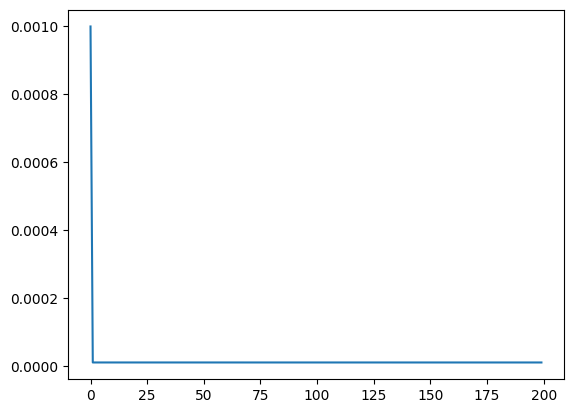

In [7]:
import matplotlib.pyplot as plt

# plt.plot(range(len(lr_history)[]), lr_history, label='LR')

plt.plot(range(200), lr_history[:200], label='LR')

In [15]:
import torch 
import torch.nn as nn 
import torch.optim as optim

from copy import deepcopy

# import torch.nn.init as init 

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)  # 첫 번째 히든 레이어
        self.fc2 = nn.Linear(hidden1, hidden2)     # 두 번째 히든 레이어
        self.fc3 = nn.Linear(hidden2, num_classes) # 출력 레이어
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # 첫 번째 히든 레이어에 ReLU 활성화 함수 적용
        x = torch.relu(self.fc2(x))  # 두 번째 히든 레이어에 ReLU 활성화 함수 적용
        x = torch.softmax(self.fc3(x), dim=1)  # 출력층에 softmax 활성화 함수 적용
        return x

# 모델 초기화
input_size = 784  # 입력 크기 (예: 28x28 픽셀 이미지를 펼친 형태)
hidden1 = 64      # 첫 번째 히든 레이어 뉴런 수
hidden2 = 32      # 두 번째 히든 레이어 뉴런 수
num_classes = 10  # 출력 클래스 수 (예: 10개의 숫자)

student = MLP(input_size, hidden1, hidden2, num_classes)
teacher = deepcopy(student)

In [20]:
import math
import torch
import torch.optim as optim

# 예시 모델의 파라미터 (실제로 사용하시는 모델의 파라미터로 대체)
model = torch.nn.Linear(10, 1)

# 초기 학습률은 base_lr = 1e-5로 설정합니다.
base_lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=base_lr)

# 총 학습 epoch 수 (예: 50)
total_epochs = 250

def lr_lambda(epoch):
    """
    epoch에 따른 LR 스케줄링 함수.
    
    - 0 <= epoch <= 10: 기초 lr(1e-5)에서 10 epoch에 1e-3이 되도록 지수적으로 증가
      1e-3 / 1e-5 = 100배 증가해야 하므로, 증가율은 exp(ln(100) * epoch/10)
    
    - epoch > 10: 10 epoch 시점의 학습률(1e-3)부터 total_epochs epoch 시점에 다시 1e-5로
      감소하도록 지수적으로 감소.
    
    lr_factor = base_lr * scale, 즉 scheduler에서는 scale만 반환합니다.
    """
    if epoch <= 10:
        # 증가: 0 epoch 에는 factor=1, 10 epoch에는 factor=100가 되어야 함.
        scale = math.exp(math.log(100) * (epoch / 10))
    else:
        # 10 epoch 부터 total_epochs epoch까지 1e-3에서 1e-5로 감소
        # 1e-5 / 1e-3 = 0.01
        decay_epochs = total_epochs - 10  # 감소하는 epoch 수
        # 현재 감소 단계: 0부터 decay_epochs 까지
        current_decay_epoch = epoch - 10
        # decay factor: 10 epoch시점의 factor는 100, total_epochs의 factor는 1.
        # 100 * (0.01)^(current_decay_epoch / decay_epochs)
        # scale = 100 * math.exp(math.log(0.01) * (current_decay_epoch / decay_epochs))
        scale = 100 * math.exp(math.log(0.2) * (current_decay_epoch / decay_epochs))
    return scale

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

lr_history = []

# 학습 loop (예제)
for epoch in range(total_epochs + 1):
    # training code ...
    optimizer.zero_grad()
    # forward, loss, backward, optimizer.step() 등
    # 예: loss.backward(), optimizer.step()
    
    # 현재 epoch의 lr 확인
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d}: lr = {current_lr:.2e}")
    
    # 스케줄러 업데이트
    scheduler.step()
    
    lr_history.append(current_lr)

Epoch 00: lr = 1.00e-05
Epoch 01: lr = 1.58e-05
Epoch 02: lr = 2.51e-05
Epoch 03: lr = 3.98e-05
Epoch 04: lr = 6.31e-05
Epoch 05: lr = 1.00e-04
Epoch 06: lr = 1.58e-04
Epoch 07: lr = 2.51e-04
Epoch 08: lr = 3.98e-04
Epoch 09: lr = 6.31e-04
Epoch 10: lr = 1.00e-03
Epoch 11: lr = 9.93e-04
Epoch 12: lr = 9.87e-04
Epoch 13: lr = 9.80e-04
Epoch 14: lr = 9.74e-04
Epoch 15: lr = 9.67e-04
Epoch 16: lr = 9.61e-04
Epoch 17: lr = 9.54e-04
Epoch 18: lr = 9.48e-04
Epoch 19: lr = 9.41e-04
Epoch 20: lr = 9.35e-04
Epoch 21: lr = 9.29e-04
Epoch 22: lr = 9.23e-04
Epoch 23: lr = 9.17e-04
Epoch 24: lr = 9.10e-04
Epoch 25: lr = 9.04e-04
Epoch 26: lr = 8.98e-04
Epoch 27: lr = 8.92e-04
Epoch 28: lr = 8.86e-04
Epoch 29: lr = 8.80e-04
Epoch 30: lr = 8.74e-04
Epoch 31: lr = 8.69e-04
Epoch 32: lr = 8.63e-04
Epoch 33: lr = 8.57e-04
Epoch 34: lr = 8.51e-04
Epoch 35: lr = 8.46e-04
Epoch 36: lr = 8.40e-04
Epoch 37: lr = 8.34e-04
Epoch 38: lr = 8.29e-04
Epoch 39: lr = 8.23e-04
Epoch 40: lr = 8.18e-04
Epoch 41: lr = 8

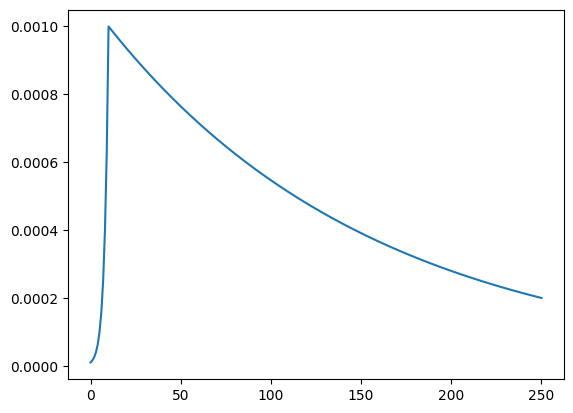

In [21]:
import matplotlib.pyplot as plt

# plt.plot(range(len(lr_history)[]), lr_history, label='LR')

plt.plot(range(len(lr_history)), lr_history, label='LR')

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
mm_linear_input = F.sigmoid(torch.randn(1, 3, 15))
mm_linear_input

tensor([[[0.4974, 0.4822, 0.4918, 0.2336, 0.7510, 0.1463, 0.5743, 0.3727,
          0.3645, 0.2764, 0.5721, 0.8429, 0.2718, 0.7389, 0.6048],
         [0.7430, 0.8658, 0.3463, 0.3430, 0.4107, 0.7142, 0.5565, 0.7733,
          0.5978, 0.6286, 0.2166, 0.6550, 0.2201, 0.6051, 0.7436],
         [0.6687, 0.4640, 0.3671, 0.4465, 0.4330, 0.5456, 0.2913, 0.8767,
          0.6541, 0.4013, 0.3494, 0.2640, 0.6193, 0.6891, 0.6165]]])

In [3]:

mm_linear_input = F.avg_pool1d(mm_linear_input, kernel_size=10, stride=5)
mm_linear_input

tensor([[[0.4190, 0.4765],
         [0.5979, 0.5711],
         [0.5148, 0.5307]]])

In [6]:
import numpy as np 

print(np.mean([0.4974, 0.4822, 0.4918, 0.2336, 0.7510, 0.1463, 0.5743, 0.3727,
          0.3645, 0.2764]))

print(np.mean([0.1463, 0.5743, 0.3727,
          0.3645, 0.2764, 0.5721, 0.8429, 0.2718, 0.7389, 0.6048]))


0.41902
0.47647000000000006
